# Dasymetric Population Mapping with Geosquare Grid

## Methodology: Binary Dasymetric Method (Eicher & Brewer, 2001)

**Reference:** Eicher, C. L., & Brewer, C. A. (2001). *Dasymetric Mapping and Areal Interpolation: Implementation and Evaluation*. Cartography and Geographic Information Science, 28(2), 125-138.

**Ancillary Data:** Building footprints from OpenStreetMap

**Grid System:** Geosquare Grid Level 12 (50m x 50m)

**Formula:**
```
Pop_grid = Pop_admin × (Building_Area_grid / Total_Building_Area_admin)
```

In [ ]:
# === CELL 1: IMPORTS ===
import geosquare_grid as gs
import geopandas as gpd
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("Dasymetric Population Mapping with Geosquare Grid")
print("Method: Binary Dasymetric (Eicher & Brewer, 2001)")
print("Ancillary: OSM Building Footprints")
print("Grid: Geosquare Level 12 (50m x 50m)")
print("="*60)

In [22]:
# === CELL 2: LOAD DATA ===
from pathlib import Path

# Define paths relative to notebook location
NOTEBOOK_DIR = Path.cwd() if '__file__' not in locals() else Path(__file__).parent
PROJECT_ROOT = NOTEBOOK_DIR.parent
BOUNDARIES_DIR = PROJECT_ROOT / 'phase1_data_hunt' / 'boundaries'
OSM_DIR = PROJECT_ROOT / 'phase1_data_hunt' / 'osm'

print("Loading data...")

# Load admin boundaries
tangsel_admin = gpd.read_file(BOUNDARIES_DIR / 'tangerang_selatan_kelurahan_RBI.geojson')
oku_admin = gpd.read_file(BOUNDARIES_DIR / 'oku_kecamatan_RBI.geojson')

# Create standardized column names from actual GDB columns
# Tangsel: NAMOBJ → kelurahan
# OKU: WADMKC → kecamatan
tangsel_admin['kelurahan'] = tangsel_admin['NAMOBJ'].str.upper().str.strip()
oku_admin['kecamatan'] = oku_admin['WADMKC'].str.upper().str.strip()

# Load building footprints
buildings_tangsel = gpd.read_file(OSM_DIR / 'osm_buildings_tangsel.geojson')
buildings_oku = gpd.read_file(OSM_DIR / 'osm_buildings_oku.geojson')

print(f"✓ Tangsel: {len(tangsel_admin)} kelurahan, {len(buildings_tangsel):,} buildings")
print(f"✓ OKU: {len(oku_admin)} kecamatan, {len(buildings_oku):,} buildings")

Loading data...
✓ Tangsel: 54 kelurahan, 135,493 buildings
✓ OKU: 13 kecamatan, 70,075 buildings


In [23]:
# === CELL 3: LOAD POPULATION DATA ===
POPULATION_DIR = PROJECT_ROOT / 'phase1_data_hunt' / 'population'

print("Loading population data...")

# Load Tangsel population
pop_tangsel = pd.read_csv(POPULATION_DIR / 'penduduk_54_tangsel_kelurahan_FINAL.csv')
pop_tangsel.columns = ['kelurahan', 'population']
pop_tangsel['kelurahan'] = pop_tangsel['kelurahan'].str.upper().str.strip()

# Load OKU population
pop_oku = pd.read_csv(POPULATION_DIR / 'penduduk_oku_clean.csv')
pop_oku = pop_oku[['kecamatan', 'jumlah']].copy()
pop_oku.columns = ['kecamatan', 'population']
pop_oku['kecamatan'] = pop_oku['kecamatan'].str.upper().str.strip()

print("\n" + "="*60)
print("POPULATION SUMMARY")
print("="*60)
print(f"Tangsel: {pop_tangsel['population'].sum():,} jiwa ({len(pop_tangsel)} kelurahan)")
print(f"OKU:     {pop_oku['population'].sum():,} jiwa ({len(pop_oku)} kecamatan)")
print("="*60)

Loading population data...

POPULATION SUMMARY
Tangsel: 1,533,870 jiwa (54 kelurahan)
OKU:     392,649 jiwa (13 kecamatan)


In [24]:
# === CELL 4: CREATE GEOSQUARE GRID ===
def create_geosquare_grid(gdf, size=50):
    """
    Create Geosquare Grid using geosquare-grid library.
    size=50 corresponds to Level 12 (50m x 50m cells)
    """
    print(f"Creating Geosquare Grid (size={size}m, Level 12)...")
    
    grid_engine = gs.GeosquareGrid()
    boundary = gdf.union_all()
    
    # Generate Geosquare grid IDs
    grid_ids = grid_engine.polyfill(boundary, size=size, fullcover=True)
    print(f"✓ Generated {len(grid_ids):,} Geosquare grid cells")
    
    # Create GeoDataFrame
    grid_data = []
    for gid in grid_ids:
        # Get geometry and coordinates for this grid
        geom = grid_engine.gid_to_geometry(gid)
        lon, lat = grid_engine.gid_to_lonlat(gid)
        
        grid_data.append({
            'grid_id': gid,
            'latitude': lat,
            'longitude': lon,
            'geometry': geom
        })
    
    grid = gpd.GeoDataFrame(grid_data, crs='EPSG:4326')
    grid_utm = grid.to_crs('EPSG:32748')  # UTM for area calculations
    
    print(f"✓ Grid GeoDataFrame created: {len(grid):,} cells")
    return grid_utm

print("\n--- Creating Tangsel Geosquare Grid ---")
grid_tangsel = create_geosquare_grid(tangsel_admin, size=50)

print("\n--- Creating OKU Geosquare Grid ---")
grid_oku = create_geosquare_grid(oku_admin, size=50)


--- Creating Tangsel Geosquare Grid ---
Creating Geosquare Grid (size=50m, Level 12)...
✓ Generated 67,649 Geosquare grid cells
✓ Grid GeoDataFrame created: 67,649 cells

--- Creating OKU Geosquare Grid ---
Creating Geosquare Grid (size=50m, Level 12)...
✓ Generated 1,529,054 Geosquare grid cells
✓ Grid GeoDataFrame created: 1,529,054 cells


In [25]:
# === CELL 5: CALCULATE BUILDING AREA PER GRID ===
def calc_building_area_per_grid(grid, buildings):
    """
    Calculate total building footprint area within each grid cell.
    """
    buildings_utm = buildings.to_crs(grid.crs)
    print(f"Calculating building area for {len(grid):,} grid cells...")
    
    # Calculate building areas
    buildings_utm['building_area'] = buildings_utm.geometry.area
    
    # Spatial join: which buildings intersect which grids
    joined = gpd.sjoin(buildings_utm[['building_area', 'geometry']], 
                       grid[['grid_id', 'geometry']], 
                       how='inner', predicate='intersects')
    
    # Sum building area per grid
    building_per_grid = joined.groupby('grid_id')['building_area'].sum().reset_index()
    building_per_grid.columns = ['grid_id', 'building_area_m2']
    
    # Merge back
    grid = grid.merge(building_per_grid, on='grid_id', how='left')
    grid['building_area_m2'] = grid['building_area_m2'].fillna(0)
    
    print(f"✓ Grids with buildings: {(grid['building_area_m2'] > 0).sum():,}")
    print(f"✓ Total building area: {grid['building_area_m2'].sum()/1e6:.2f} km²")
    return grid

print("\n--- Processing Tangsel ---")
grid_tangsel = calc_building_area_per_grid(grid_tangsel, buildings_tangsel)

print("\n--- Processing OKU ---")
grid_oku = calc_building_area_per_grid(grid_oku, buildings_oku)


--- Processing Tangsel ---
Calculating building area for 67,649 grid cells...
✓ Grids with buildings: 27,872
✓ Total building area: 46.44 km²

--- Processing OKU ---
Calculating building area for 1,529,054 grid cells...
✓ Grids with buildings: 23,902
✓ Total building area: 16.39 km²


In [26]:
# === CELL 6: ASSIGN GRID TO ADMIN UNIT ===
def assign_grid_to_admin(grid, admin, admin_col):
    """
    Assign each grid cell to its administrative unit.
    """
    admin_utm = admin.to_crs(grid.crs)
    
    # Use centroid for assignment
    grid_centroids = grid.copy()
    grid_centroids['geometry'] = grid_centroids.geometry.centroid
    
    # Spatial join
    joined = gpd.sjoin(grid_centroids[['grid_id', 'geometry']], 
                       admin_utm[[admin_col, 'geometry']], 
                       how='left', predicate='within')
    
    grid = grid.merge(joined[['grid_id', admin_col]], on='grid_id', how='left')
    print(f"✓ Grids assigned to {grid[admin_col].nunique()} admin units")
    return grid

print("\n--- Assigning Tangsel grids to Kelurahan ---")
grid_tangsel = assign_grid_to_admin(grid_tangsel, tangsel_admin, 'kelurahan')

print("\n--- Assigning OKU grids to Kecamatan ---")
grid_oku = assign_grid_to_admin(grid_oku, oku_admin, 'kecamatan')


--- Assigning Tangsel grids to Kelurahan ---
✓ Grids assigned to 54 admin units

--- Assigning OKU grids to Kecamatan ---
✓ Grids assigned to 13 admin units


In [27]:
# === CELL 7: DASYMETRIC POPULATION DISTRIBUTION ===
def dasymetric_distribution(grid, pop_df, admin_col):
    """
    Binary Dasymetric Method (Eicher & Brewer, 2001).
    
    Formula: Pop_grid = Pop_admin × (Building_Area_grid / Total_Building_Area_admin)
    """
    print("Applying Binary Dasymetric Method...")
    
    # Merge population
    grid = grid.merge(pop_df, on=admin_col, how='left')
    
    # Total building area per admin unit
    total_building = grid.groupby(admin_col)['building_area_m2'].sum().reset_index()
    total_building.columns = [admin_col, 'total_building_area_admin']
    grid = grid.merge(total_building, on=admin_col, how='left')
    
    # Calculate weight and distribute
    grid['weight'] = grid['building_area_m2'] / grid['total_building_area_admin']
    grid['weight'] = grid['weight'].fillna(0)
    grid['estimated_pop'] = grid['population'] * grid['weight']
    grid['estimated_pop'] = grid['estimated_pop'].fillna(0)
    
    # Population density per km²
    grid_area_km2 = 0.05 * 0.05  # 50m × 50m = 0.0025 km²
    grid['pop_density_km2'] = grid['estimated_pop'] / grid_area_km2
    
    print(f"✓ Total population distributed: {grid['estimated_pop'].sum():,.0f}")
    print(f"✓ Max population per grid: {grid['estimated_pop'].max():.1f}")
    print(f"✓ Grids with population: {(grid['estimated_pop'] > 0).sum():,}")
    return grid

print("\n--- Distributing Tangsel Population ---")
grid_tangsel = dasymetric_distribution(grid_tangsel, pop_tangsel, 'kelurahan')

print("\n--- Distributing OKU Population ---")
grid_oku = dasymetric_distribution(grid_oku, pop_oku, 'kecamatan')


--- Distributing Tangsel Population ---
Applying Binary Dasymetric Method...
✓ Total population distributed: 1,533,870
✓ Max population per grid: 2915.3
✓ Grids with population: 27,767

--- Distributing OKU Population ---
Applying Binary Dasymetric Method...
✓ Total population distributed: 392,649
✓ Max population per grid: 591.1
✓ Grids with population: 23,885


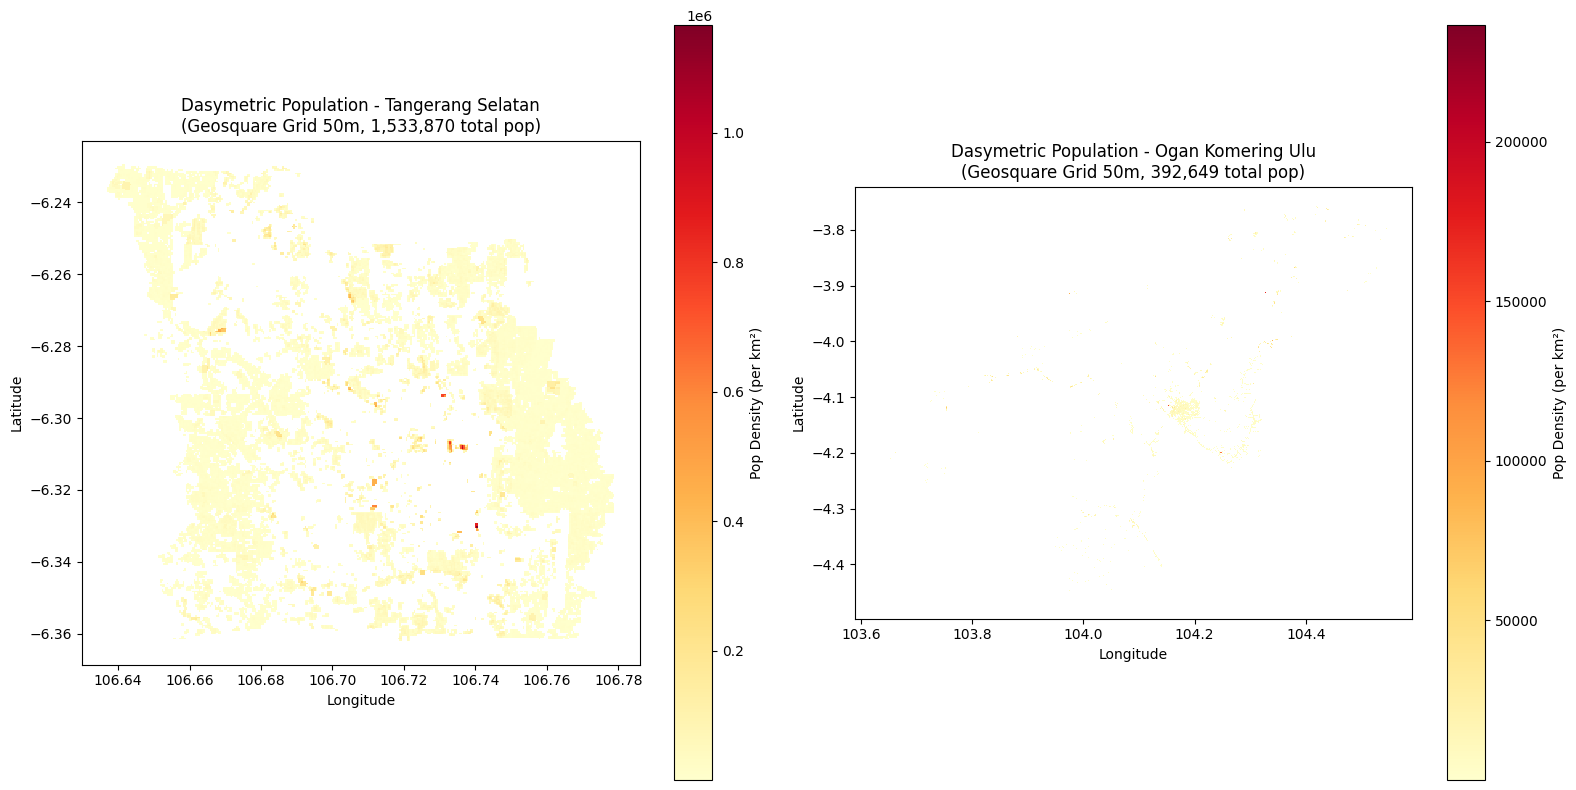


✓ Saved: /home/leonk/Documents/geosquare/phase3_dasymetric/outputs/dasymetric_population_map.png


In [28]:
# === CELL 8: VISUALIZATION ===
import matplotlib.pyplot as plt

# Create output directory
OUTPUT_DIR = NOTEBOOK_DIR / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Tangsel
ax1 = axes[0]
grid_tangsel_viz = grid_tangsel.to_crs('EPSG:4326')
grid_tangsel_viz[grid_tangsel_viz['estimated_pop'] > 0].plot(
    column='pop_density_km2', cmap='YlOrRd', legend=True,
    legend_kwds={'label': 'Pop Density (per km²)'}, ax=ax1
)
ax1.set_title(f'Dasymetric Population - Tangerang Selatan\n(Geosquare Grid 50m, {grid_tangsel["estimated_pop"].sum():,.0f} total pop)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# OKU
ax2 = axes[1]
grid_oku_viz = grid_oku.to_crs('EPSG:4326')
grid_oku_viz[grid_oku_viz['estimated_pop'] > 0].plot(
    column='pop_density_km2', cmap='YlOrRd', legend=True,
    legend_kwds={'label': 'Pop Density (per km²)'}, ax=ax2
)
ax2.set_title(f'Dasymetric Population - Ogan Komering Ulu\n(Geosquare Grid 50m, {grid_oku["estimated_pop"].sum():,.0f} total pop)')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.tight_layout()
output_file = OUTPUT_DIR / 'dasymetric_population_map.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {output_file}")

In [29]:
# === CELL 9: SAVE OUTPUT ===
# Convert to WGS84
grid_tangsel_out = grid_tangsel.to_crs('EPSG:4326')
grid_oku_out = grid_oku.to_crs('EPSG:4326')

# Add lat/lon columns
grid_tangsel_out['lon'] = grid_tangsel_out['longitude']
grid_tangsel_out['lat'] = grid_tangsel_out['latitude']
grid_oku_out['lon'] = grid_oku_out['longitude']
grid_oku_out['lat'] = grid_oku_out['latitude']

# Save GeoJSON
out_cols_tangsel = ['grid_id', 'kelurahan', 'building_area_m2', 'estimated_pop', 'pop_density_km2', 'lat', 'lon', 'geometry']
tangsel_geojson = OUTPUT_DIR / 'pop_grid_tangsel.geojson'
grid_tangsel_out[out_cols_tangsel].to_file(tangsel_geojson, driver='GeoJSON')
print(f"✓ {tangsel_geojson} ({len(grid_tangsel_out):,} grids)")

out_cols_oku = ['grid_id', 'kecamatan', 'building_area_m2', 'estimated_pop', 'pop_density_km2', 'lat', 'lon', 'geometry']
oku_geojson = OUTPUT_DIR / 'pop_grid_oku.geojson'
grid_oku_out[out_cols_oku].to_file(oku_geojson, driver='GeoJSON')
print(f"✓ {oku_geojson} ({len(grid_oku_out):,} grids)")

# Save CSV (for Geosquare platform integration)
csv_cols_tangsel = ['grid_id', 'kelurahan', 'building_area_m2', 'estimated_pop', 'pop_density_km2', 'lat', 'lon']
tangsel_csv = OUTPUT_DIR / 'pop_grid_tangsel.csv'
grid_tangsel_out[csv_cols_tangsel].to_csv(tangsel_csv, index=False)
print(f"✓ {tangsel_csv}")

csv_cols_oku = ['grid_id', 'kecamatan', 'building_area_m2', 'estimated_pop', 'pop_density_km2', 'lat', 'lon']
oku_csv = OUTPUT_DIR / 'pop_grid_oku.csv'
grid_oku_out[csv_cols_oku].to_csv(oku_csv, index=False)
print(f"✓ {oku_csv}")

print("\n=== DASYMETRIC MAPPING COMPLETE ===")

✓ /home/leonk/Documents/geosquare/phase3_dasymetric/outputs/pop_grid_tangsel.geojson (67,649 grids)
✓ /home/leonk/Documents/geosquare/phase3_dasymetric/outputs/pop_grid_oku.geojson (1,529,054 grids)
✓ /home/leonk/Documents/geosquare/phase3_dasymetric/outputs/pop_grid_tangsel.csv
✓ /home/leonk/Documents/geosquare/phase3_dasymetric/outputs/pop_grid_oku.csv

=== DASYMETRIC MAPPING COMPLETE ===


In [30]:
# === CELL 10: SUMMARY STATISTICS ===
print("="*70)
print("DASYMETRIC POPULATION MAPPING - SUMMARY")
print("="*70)
print(f"\nMethodology: Binary Dasymetric (Eicher & Brewer, 2001)")
print(f"Ancillary Data: OSM Building Footprints")
print(f"Grid System: Geosquare Level 12 (50m x 50m)")

print(f"\n{'Metric':<30} {'Tangsel':>15} {'OKU':>15}")
print("-"*60)
print(f"{'Total Grid Cells':<30} {len(grid_tangsel):>15,} {len(grid_oku):>15,}")
print(f"{'Grids with Buildings':<30} {(grid_tangsel['building_area_m2']>0).sum():>15,} {(grid_oku['building_area_m2']>0).sum():>15,}")
print(f"{'Grids with Population':<30} {(grid_tangsel['estimated_pop']>0).sum():>15,} {(grid_oku['estimated_pop']>0).sum():>15,}")
print(f"{'Total Population':<30} {grid_tangsel['estimated_pop'].sum():>15,.0f} {grid_oku['estimated_pop'].sum():>15,.0f}")
print(f"{'Max Pop per Grid':<30} {grid_tangsel['estimated_pop'].max():>15.1f} {grid_oku['estimated_pop'].max():>15.1f}")
print(f"{'Mean Pop Density (km²)':<30} {grid_tangsel['pop_density_km2'].mean():>15,.0f} {grid_oku['pop_density_km2'].mean():>15,.0f}")
print("-"*60)
print(f"\n📁 Output Files:")
print(f"   - {OUTPUT_DIR.name}/pop_grid_tangsel.geojson")
print(f"   - {OUTPUT_DIR.name}/pop_grid_tangsel.csv")
print(f"   - {OUTPUT_DIR.name}/pop_grid_oku.geojson")
print(f"   - {OUTPUT_DIR.name}/pop_grid_oku.csv")
print(f"   - {OUTPUT_DIR.name}/dasymetric_population_map.png")
print(f"\n💾 Full path: {OUTPUT_DIR}")
print("="*70)

DASYMETRIC POPULATION MAPPING - SUMMARY

Methodology: Binary Dasymetric (Eicher & Brewer, 2001)
Ancillary Data: OSM Building Footprints
Grid System: Geosquare Level 12 (50m x 50m)

Metric                                 Tangsel             OKU
------------------------------------------------------------
Total Grid Cells                        67,649       1,529,054
Grids with Buildings                    27,872          23,902
Grids with Population                   27,767          23,885
Total Population                     1,533,870         392,649
Max Pop per Grid                        2915.3           591.1
Mean Pop Density (km²)                   9,070             103
------------------------------------------------------------

📁 Output Files:
   - outputs/pop_grid_tangsel.geojson
   - outputs/pop_grid_tangsel.csv
   - outputs/pop_grid_oku.geojson
   - outputs/pop_grid_oku.csv
   - outputs/dasymetric_population_map.png

💾 Full path: /home/leonk/Documents/geosquare/phase3_dasymet